# Modeling & managing negative predictions

In the previous notebook I was working with, linear regression models consistently provided MAPE scores well above 800% and RMSE errors of around 120,000,000. Neither of those are acceptable metric scores.  

I believe that these errors are the result of two things: Outliers in the target variable, and high dimensionality.  

This notebook I'll be taking a look at revenue outliers, and test different transformations that I can do with numeric data to produce better scores.  One of the problems that stood out with linear model predictions in the previous notebook was that I was consistently producing ~60 negative revenue predictions, which certaintly contributed to the poor error metrics. That also prevended me from using the mean_squared_log_error metric as well.  

First I'm going to try using a MinMaxScaler instead of StandardScaler to see if I can eliminate negative predictions and how that affects scores. 

I'll also attempt to log transform the revenue data I have.  Currently it is highly skewed by outliers and has a non-normal distribution.  I believe a log transformation could improve the impact the revenue distribution will have on metrics. 

Finally, I'm going to eliminate any outliers in revenue, as defined by films in the top 5% of revenue. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
# Importing the data
boxoffice = pd.read_csv('../Data/boxoffice_PreProcess.csv', index_col=0, header=[0,1])
boxoffice.shape

(2333, 9976)

Before I move forward I need to revisit the predictions from a linear model in my previous notebook and determine where and why I was generating negative predictions for revenue in my previous notebook 

In [3]:
# separate out the target variable and scale the independent numerical variables
y = boxoffice['Numerical', 'revenue']
X = boxoffice.drop('revenue', level=1, axis=1)
scaler = StandardScaler()
X['Numerical'] = scaler.fit_transform(X['Numerical'])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# instantiate a linear regression model and test for negative predictions
# in a previous notebook these prevented me from using the mean_squared_log_error
linear = LinearRegression()
linear.fit(X_train, y_train)
preds = linear.predict(X_test)
print(len(preds[preds < 0]))
set1 = set(y_test[preds<0].index)
print("Baseline R2 score: ", r2_score(y_test, preds))
print("Baseline RMSE score: ", np.sqrt(mean_squared_error(y_test, preds)))

65
Baseline R2 score:  0.3293102238022876
Baseline RMSE score:  133817802.53673649


Mean revenue value of the data set:  147844739.08444065
These values were predicted as negative, true values are greater than the mean revenue:  464    408247917.00000
1483   183593586.00000
1041   161001698.00000
Name: (Numerical, revenue), dtype: float64


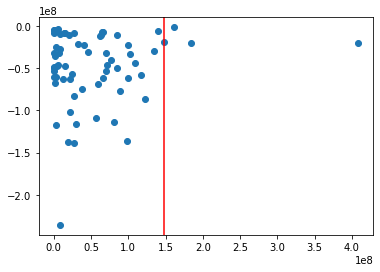

In [6]:
# Trying to examine the negative predictions to determine if there's a pattern, perhaps lower values are predicted as negative
print('Mean revenue value of the data set: ', y.mean())
print('These values were predicted as negative, true values are greater than the mean revenue: ',
      y_test[preds<0][y_test>y.mean()])
plt.scatter(y_test[preds<0].values, preds[preds<0])
plt.axvline(y.mean(), c='r');

My hypothesis was that the predicted negative values were a result of the linear model predicting low-value films exceptionally low.

Multiple of the films with values predicted as negative have a true revenue value that is above the mean revenue for the entire data set. While negative predictions are less severe and less common as a film's true revenueincreases, this problem doesn't seem to be restricted to only low-revenue films. This disproves my hypothesis that negative predictions were a result of a film's true value being close to zero. 

I do want to test and see if using a MinMaxScaler instead of the StandardScaler will result in better predictions.  Since StandardScaler produces negative features that could be part of the problem.   

Additionally there is a severe right tail for the target revenue on this problem, using a logarithmic transformation should in theory help to rectify this.  This is something I realized after doing further research on [stackexchange](https://stats.stackexchange.com/questions/145383/getting-negative-predicted-values-after-linear-regression/145387)

If neither of those methods prevent negative revenue predictions, I'll have to remove outliers for revenue and then begin to reduce dimensionality. 

In [7]:
# Recreating and identical train/test split using a different scaler, potentially negative values for numeric data are
# leading to negative values in some cases
y = boxoffice['Numerical', 'revenue']
X = boxoffice.drop('revenue', level=1, axis=1)
scaler = MinMaxScaler()
X['Numerical'] = scaler.fit_transform(X['Numerical'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# create a 2nd regressor and test for negative revenue predictions
linear2 = LinearRegression()
linear2.fit(X_train, y_train)
preds = linear2.predict(X_test)
print(len(preds[preds < 0]))
set2 = set(y_test[preds<0].index)
print("Min/Max R2 score: ", r2_score(y_test, preds))
print("Min/Max RMSE score: ", np.sqrt(mean_squared_error(y_test, preds)))

60
Min/Max R2 score:  0.30525955844415265
Min/Max RMSE score:  136195996.31318033


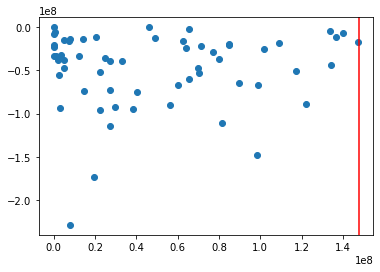

In [9]:
# examining which values are produced as negative with a new scaler to see if there's a noticeable difference in distribution
# after removing negative values from the independent variables
plt.scatter(y_test[preds<0].values, preds[preds<0])
plt.axvline(y.mean(), c='r');

While using MinMaxScaler produced *fewer* negative predictions, and those films who produce negative predictions are less than the average, the number of predictions below zero didn't decrease significantly. It also appears that the magnitude of a negative prediction has little relationship with the actual revenue of a film. 

It's time to try a logarithmic transformation on the revenue column as I mentioned earlier to test if that will prevent negative predictions. 

### Applying a log transformation to revenue in order to eliminate negative predictions

I want to be able to use mean_squared_log_error as a metric for evaluating these models, but that's impossible as long as I'm producing negative results.

In [10]:
# Recreating the identical train/test split after applying a logarithmic transformation to the target variable
y = np.log(boxoffice['Numerical', 'revenue'])
X = boxoffice.drop('revenue', level=1, axis=1)
scaler = MinMaxScaler()
X['Numerical'] = scaler.fit_transform(X['Numerical'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

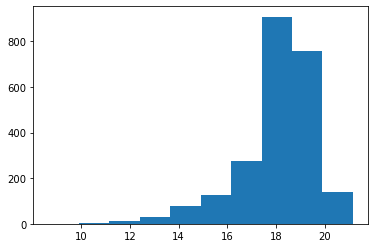

In [12]:
plt.hist(y);

In [13]:
linear_log = LinearRegression()
linear_log.fit(X_train, y_train)
preds = linear2.predict(X_test)
set3 = set(y_test[preds<0].index)
print("Log R2 score: ", r2_score(y_test, preds))
print("Log RMSE score: ", np.sqrt(mean_squared_error(y_test, preds)))
print(len(preds[preds < 0]))

Log R2 score:  -1.7879622231347356e+16
Log RMSE score:  204965664.0608331
60


In [14]:
print(set1.difference(set3))
print(set2.difference(set3))

{1888, 1761, 1987, 1315, 1124, 1929, 1483, 76, 464, 1041, 368, 414}
set()


Still getting negative predictions after applying a logarithmic transformation.  The same films are providing negative predictions before and after applying a logarithmic transformation to the revenue column, while doing so has also dramatically decreased the R-squared score for the model.  

Additionally, applying a logarithmic transformation to the data has done nothing to normalize the revenue, but rather exchanged a long right-tail distribution for a long left-tailed distribution instead. 

At this point I'm going to remove the outliers for revenue based on quantile. Given the results of a log transformation I won't use such a transformation on the target variables moving forward.  

### Removing outliers

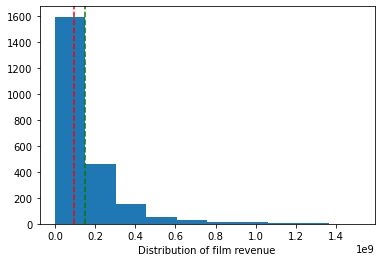

In [15]:
plt.hist(boxoffice['Numerical', 'revenue'])
plt.xlabel('Distribution of film revenue')
plt.axvline(boxoffice['Numerical', 'revenue'].mean(), c='g', linestyle='--')
plt.axvline(boxoffice['Numerical', 'revenue'].median(), c='r', linestyle='--');

(2216, 9976)


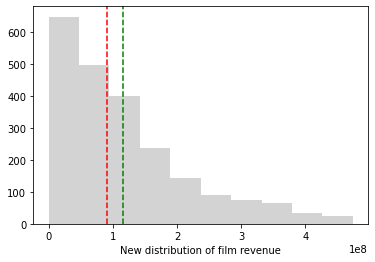

In [16]:
quant = boxoffice['Numerical', 'revenue'].quantile(0.95)
boxoffice = boxoffice[boxoffice['Numerical', 'revenue']<quant]
plt.hist(boxoffice['Numerical', 'revenue'], color = 'lightgrey')
plt.xlabel('New distribution of film revenue')
plt.axvline(boxoffice['Numerical', 'revenue'].mean(), c='g', linestyle='--')
plt.axvline(boxoffice['Numerical', 'revenue'].median(), c='r', linestyle='--');
print(boxoffice.shape)

In [17]:
y = boxoffice['Numerical', 'revenue']
X = boxoffice.drop('revenue', level=1, axis=1)
scaler = MinMaxScaler()
X['Numerical'] = scaler.fit_transform(X['Numerical'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Testing linear model scores after removing the outlier films
linear = LinearRegression()
linear.fit(X_train, y_train)
preds = linear.predict(X_test)
print(len(preds[preds<0]))
set4 = set(y_test[preds<0].index)
print("New R2 score: ", r2_score(y_test, preds))
print("New RMSE score: ", np.sqrt(mean_squared_error(y_test, preds)))

33
New R2 score:  0.09257204234821903
New RMSE score:  91804028.1876023


In [19]:
# checking to see if that completely removed all the films that provided a negative value previously
print(set4.intersection(set2))
print(set4.intersection(set1))

{841, 1466, 1902}
{841, 1466, 1902}


Even after removing outliers I'm still getting negative predictions. I've also significantly reduced my R-squared score by removing outliers.  However this is the lowest I've had my RMSE score since I began working with this data.

A linear regression model doesn't appear to be the best fit for the data set.  It's also interesting that I'm getting lower R-squared scores than I was previously.  For now I'm going to work to reduce dimensionality in my data set before trying out different regression models. 

I'm going to save the data for use in another notebook focused on reducing dimensionality.  

In [20]:
boxoffice.to_csv('../Data/No_Outliers.csv')

I'm unsatsified with the results I'm getting thus far.  While this is the first project I've worked on I know that it's possible to be getting significantly better [results](https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation). 

To conclude this notebook I'm going to test how a Random Forest regressor on this data without outliers.  

In the next notebook I'm going to reduce the dimensionality of the data I'm working with significantly and see if that will improve scores. 

### Random Forest Modeling

Given that a linear model seems to be performing poorly on the data as it is, I want to check to see what the results are from using a decision tree regression model like Random Forest are after removing outliers from this data set.

In [21]:
y = boxoffice['Numerical', 'revenue']
X = boxoffice.drop('revenue', level=1, axis=1)
scaler = StandardScaler()
X['Numerical'] = scaler.fit_transform(X['Numerical'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

In [22]:
rand = RandomForestRegressor()
rand.fit(X_train, y_train)
preds = rand.predict(X_test)
print(len(preds[preds<0]))
print("Random Forest R2 score: ", r2_score(y_test, preds))
print("Random Forest RMSE score: ", np.sqrt(mean_squared_error(y_test, preds)))

0
Random Forest R2 score:  0.38562738400913943
Random Forest RMSE score:  81873619.95980084


# Conclusion

It seems that a random forest regression model produces the best results yet!  None of the linear models have produced **both**  a R-squared score as high as 0.383 and a RMSE score as low as 82,082,297.  

The next step to continue improving modeling & preprocessing scores by reducing dimensionality in the data set before trying more robust ML models. 